In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans

import common.loss_utils as loss_utils

import sys
sys.path.append('utae-paps')
from src.backbones import utae_mod as utae_forecaster

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [5]:
FORECAST = 17
BATCH_SIZE = 8

In [6]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [7]:
_MEDIAN_PIXEL = 212.0
_IQR = 213.0

deltas = np.linspace(-2.0, 2.0, num=81).reshape(-1,1)
_KM = KMeans()
_KM.cluster_centers_ = deltas
_KM._n_threads = 1

def transform(x):
    return np.tanh((x - _MEDIAN_PIXEL) / _IQR)

def transform_y(y, starter):
    y = transform(y)
    y = y - starter
    y_grouped = _KM.predict(y.reshape(-1,1))
    y_grouped = y_grouped.reshape(y.shape)
    return y_grouped

def check_times(tstart, tend):
    # check_times(times[0], times[35])
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.generator.randint(0, input_slice.shape[1] - 128)

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        y = y[:FORECAST] # chop forecast
        x = transform(x)
        x_last = x[-1]
        x = x - x_last
        y_trans = transform_y(y, x_last[32:96,32:96])
        return x, y_trans, x_last, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
#     num_workers=1,
#     prefetch_factor=1
)

In [8]:
ex_x, ex_y, _, _ = ds[0]

In [9]:
ex_x.shape, ex_y.shape

((12, 128, 128), (17, 64, 64))

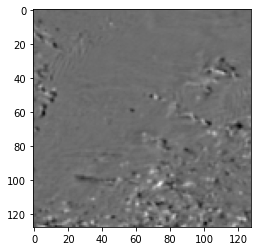

In [10]:
plt.imshow(ex_x[-2], cmap='gray')

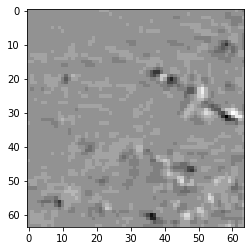

In [11]:
plt.imshow(ex_y[0], cmap='gray')

In [13]:
model = utae_forecaster.UTAE(
    forecast_steps=FORECAST,
    input_dim=1, # 10 for paper
    encoder_widths=[64, 64, 64, 128],
    decoder_widths=[32, 32, 64, 128],
    out_conv=[32, len(deltas)],
    str_conv_k=4,
    str_conv_s=2,
    str_conv_p=1,
    agg_mode="att_group",
    encoder_norm="group",
    n_head=16,
    d_model=256,
    d_k=4,
    encoder=False,
    return_maps=False,
    pad_value=None, # 0
    padding_mode="reflect",
)

model.load_state_dict(torch.load("weights/300d_imagediff_forecast=17/utae_epochs=16_batch=7999_loss=4.0767.pt"))
model = model.to(DEVICE)


In [14]:
STOP_BATCH = int(500/BATCH_SIZE)
STOP_BATCH

62

In [15]:
# get accuracy
model.eval()

running_correct = 0
running_total = 0
for i, (srcs, trgs, _, _) in enumerate(tqdm.tqdm(dl)):
    if i > STOP_BATCH:
        break
    xi = srcs.float().to(DEVICE)
    yi = trgs.long().to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi)
        
    preds = torch.argmax(preds, dim=2)
    running_correct += (preds == yi).sum()
    running_total += yi.reshape(-1).shape[0]
    

  3%|▎         | 63/2290 [00:40<23:51,  1.56it/s] 


In [16]:
running_correct/running_total

tensor(0.1158, device='cuda:0')

In [17]:
_means = torch.FloatTensor(deltas).to(DEVICE)
_means = torch.unsqueeze(torch.unsqueeze(_means, 0), 3)

def get_img(preds):
    class_dim = 2
    m = preds.max(dim=class_dim).values
    m = torch.unsqueeze(m, dim=class_dim)
    preds = preds - m
    a = torch.exp(preds)
    v = a.sum(dim=class_dim)
    e = a / torch.unsqueeze(v, class_dim)
    r = torch.sum(e * _means, axis=class_dim)
    return r

In [18]:
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=FORECAST)


In [25]:
model.eval()

losses = []
pbar = tqdm.tqdm(dl)
for i, (srcs, _, x_last, trgs) in enumerate(pbar):
    if i > STOP_BATCH:
        break
    xi = srcs.float().to(DEVICE)
    yi = trgs.float().to(DEVICE)
    x_last = x_last.float().to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi)
    
    x_last_inner = x_last[:,32:96,32:96]
    x_last_inner = torch.unsqueeze(x_last_inner, dim=1)
    preds = get_img(preds)
    preds = preds + x_last_inner
    preds[preds > 1] = 0.999
    preds[preds < -1] = -0.999
    preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL

    loss = criterion(preds, yi)
    losses.append(loss.item())
    if i % 1 == 0:
        l = round(np.mean(losses), 4)
        pbar.set_description(f'Avg MS-SSIM: {l}')
    break

Avg MS-SSIM: 0.5515:   0%|          | 0/2290 [00:00<?, ?it/s]


In [22]:
np.mean(losses)

0.6460050510035621